# Problem Statement 

On Kalshi there is a market where you can wager how the Nasdaq 100 will perform and what value it will close that day. You are provided several options to choose which are ranges of values of the spread 100 points example(14000-14100 , 14101-14200). We want to look at the data to get a better understandin if we can prdeict what the performance of that day will be by looking at the open and the amount of volume traded on that day. My theory is that the open and close values are never more than 200 points apart on an average day. We are going to test this and see if it falls in the provided ranges to see if we can learn when and where we can place our prediction

# Sourcing Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
values = pd.read_csv('nasdaq_100_trading_data.csv')
values.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-23,7420.310059,7465.870117,7405.399902,7413.839844,7413.839844,1888600000
1,2018-08-24,7443.709961,7489.540039,7442.990234,7485.399902,7485.399902,1892990000
2,2018-08-27,7527.370117,7560.759766,7512.020020,7559.129883,7559.129883,2333790000
3,2018-08-28,7580.850098,7588.720215,7556.709961,7570.250000,7570.250000,1980270000
4,2018-08-29,7585.129883,7661.950195,7583.520020,7660.180176,7660.180176,1909880000


# Data Cleaning

In [3]:
# Change date from object to datetime
values['Date'] = pd.to_datetime(values['Date'])

In [4]:
# Creating columns of high low spreads and open close spread
values['OC Difference'] = values['Open']-values['Close']
values['HL Difference'] = values['High']-values['Low']

In [5]:
# Creating column to denote day of the week
values['DayOfWeek'] = values['Date'].dt.dayofweek

# Mapping numerical day of the week to corresponding day names
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
values['DayOfWeek'] = values['DayOfWeek'].map(lambda x: day_names[x])

In [6]:
#rearrange column order
column_order = ['Date', 'DayOfWeek', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','OC Difference','HL Difference']
values = values[column_order]

In [7]:
# Open close percent change intraday
values['OC %Change'] = (values['Close'] - values['Open']) / values['Open']

In [8]:
#high low percent change intraday
values['HL %Change'] = (values['Low'] - values['High']) / values['High']

In [9]:
# Column to denote if todays close is hgiher than yesterdays close. 1 if yes, 0 if no
values['Close_Status'] = (values['Close'] > values['Close'].shift()).astype(int)

In [10]:
#Column to display change between todays close against yesterdays close
values['Close_Difference'] = values['Close'] - values['Close'].shift()

In [11]:
values.tail()

,Date,DayOfWeek,Open,High,Low,Close,Adj Close,Volume,OC Difference,HL Difference,OC %Change,HL %Change,Close_Status,Close_Difference
1252,2023-08-16,Wednesday,15021.629883,15077.049805,14874.019531,14876.469727,14876.469727,6243760000,145.160156,203.030274,-0.009663,-0.013466,0,-161.180664
1253,2023-08-17,Thursday,14943.339844,14949.580078,14698.290039,14715.809570,14715.809570,5280180000,227.530274,251.290039,-0.015226,-0.016809,0,-160.660157
1254,2023-08-18,Friday,14589.709961,14744.570313,14557.830078,14694.839844,14694.839844,4801910000,-105.129883,186.740235,0.007206,-0.012665,0,-20.969726
1255,2023-08-21,Monday,14762.009766,14958.870117,14739.370117,14936.690430,14936.690430,4363070000,-174.680664,219.500000,0.011833,-0.014674,1,241.850586
1256,2023-08-22,Tuesday,15035.070313,15037.790039,14883.980469,14908.959961,14908.959961,4282430000,126.110352,153.809570,-0.008388,-0.010228,0,-27.730469


In [12]:
#Im adding a bunch more coloumns here that I am not sure I will need down the line but is a good to have:

# Calculate Average Open-Close Spread (Moving Average)
values['Avg_OC_Spread_10_Day'] = values['Close_Difference'].rolling(window=10).mean()

In [13]:
# Calculate Average Volume (Moving Average)
values['Avg_Volume_10_Day'] = values['Volume'].rolling(window=10).mean()

In [14]:
# Calculate Volatility (Standard Deviation of Open-Close Spread)
values['Volatility_10_Day'] = values['Close_Difference'].rolling(window=10).std()

In [15]:
# Calculate Price Change Magnitude
values['Price_Change_Magnitude'] = abs(values['Close_Difference'])

In [16]:
# Create Price Direction Column
values['Price_Direction'] = pd.cut(values['Close_Difference'], bins=[float('-inf'), 0, float('inf')], labels=[0,1])

In [17]:
# Calculate Moving Average Volume Ratio
values['MA_Volume_Ratio'] = values['Volume'] / values['Avg_Volume_10_Day']

In [18]:
# Create Day Type Change Column
values['Day_Type_Change'] = (values['DayOfWeek'] != values['DayOfWeek'].shift()).astype(int)

In [19]:
values.tail()

,Date,DayOfWeek,Open,High,Low,Close,Adj Close,Volume,OC Difference,HL Difference,...,HL %Change,Close_Status,Close_Difference,Avg_OC_Spread_10_Day,Avg_Volume_10_Day,Volatility_10_Day,Price_Change_Magnitude,Price_Direction,MA_Volume_Ratio,Day_Type_Change
1252,2023-08-16,Wednesday,15021.629883,15077.049805,14874.019531,14876.469727,14876.469727,6243760000,145.160156,203.030274,...,-0.013466,0,-161.180664,-49.427051,5.208172e+09,126.417231,161.180664,0,1.198839,1
1253,2023-08-17,Thursday,14943.339844,14949.580078,14698.290039,14715.809570,14715.809570,5280180000,227.530274,251.290039,...,-0.016809,0,-160.660157,-63.773047,5.132493e+09,130.430060,160.660157,0,1.028775,1
1254,2023-08-18,Friday,14589.709961,14744.570313,14557.830078,14694.839844,14694.839844,4801910000,-105.129883,186.740235,...,-0.012665,0,-20.969726,-58.008008,5.077739e+09,130.973846,20.969726,0,0.945679,1
1255,2023-08-21,Monday,14762.009766,14958.870117,14739.370117,14936.690430,14936.690430,4363070000,-174.680664,219.500000,...,-0.014674,1,241.850586,-47.115918,5.024813e+09,151.532517,241.850586,1,0.868305,1
1256,2023-08-22,Tuesday,15035.070313,15037.790039,14883.980469,14908.959961,14908.959961,4282430000,126.110352,153.809570,...,-0.010228,0,-27.730469,-36.408984,4.924601e+09,148.398817,27.730469,0,0.869599,1


# Exploratory Data Analysis

In [20]:
# Summary Statistics
summary_stats = values.describe()
print(summary_stats)

               Open          High           Low         Close     Adj Close  \
count   1257.000000   1257.000000   1257.000000   1257.000000   1257.000000   
mean   11264.225881  11356.788891  11165.991191  11267.085563  11267.085563   
std     2943.721954   2962.225306   2920.472896   2942.534415   2942.534415   
min     5969.080078   6075.169922   5895.120117   5899.350098   5899.350098   
25%     8010.049805   8108.609863   7940.450195   8029.220215   8029.220215   
50%    11704.459961  11840.070313  11579.639648  11725.849609  11725.849609   
75%    13647.730469  13714.440430  13524.530273  13641.750000  13641.750000   
max    16644.769531  16764.859375  16523.830078  16573.339844  16573.339844   

             Volume  OC Difference  HL Difference   OC %Change   HL %Change  \
count  1.257000e+03    1257.000000    1257.000000  1257.000000  1257.000000   
mean   4.070644e+09      -2.859683     190.797700     0.000367    -0.016863   
std    1.483523e+09     144.326008     120.231774  

### Visualizations

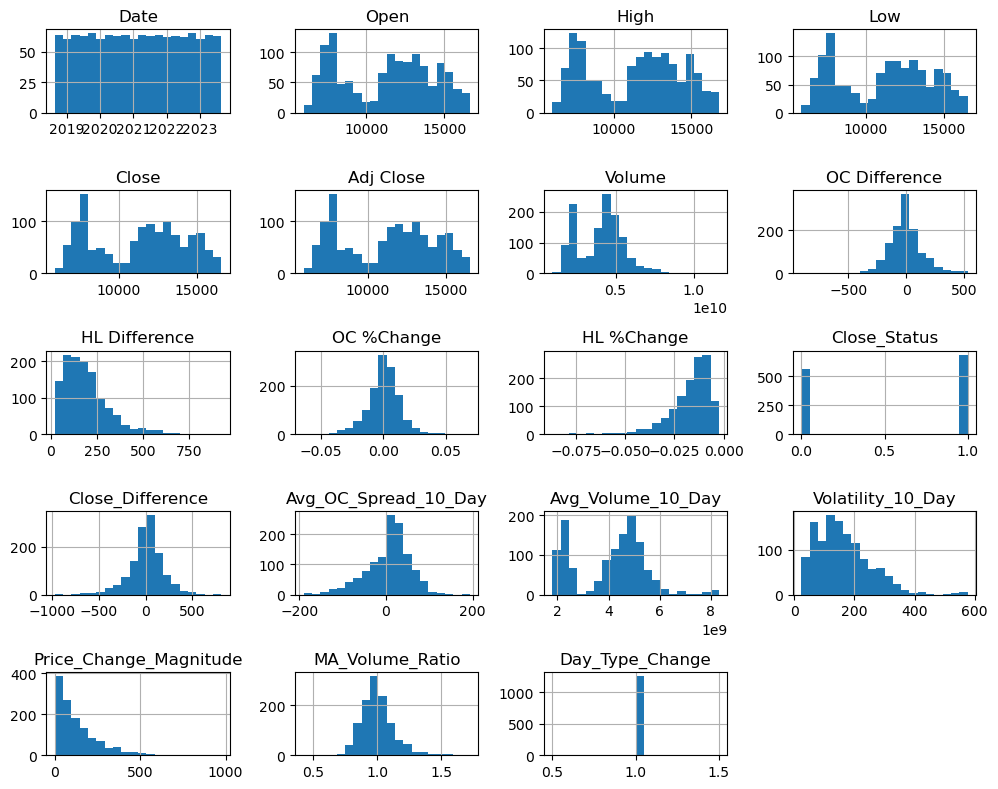

In [21]:
# Histograms and Density Plots
values.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

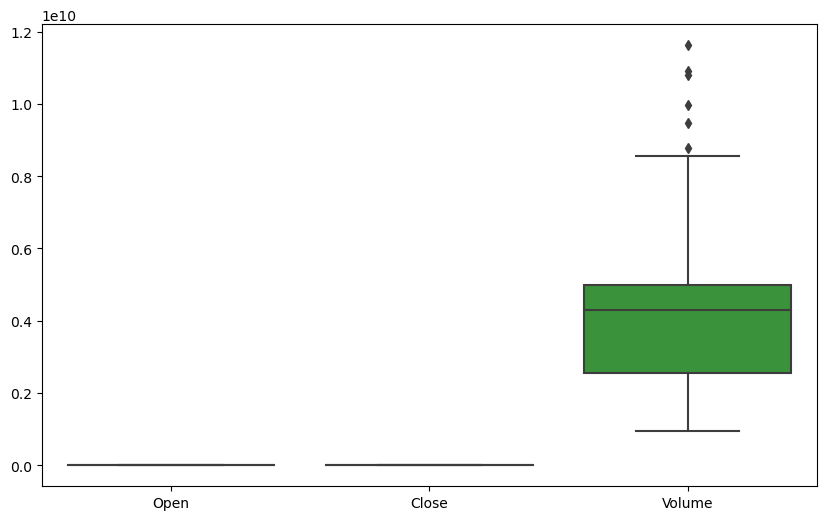

In [22]:
# Box Plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=values[['Open', 'Close', 'Volume']])
plt.show()

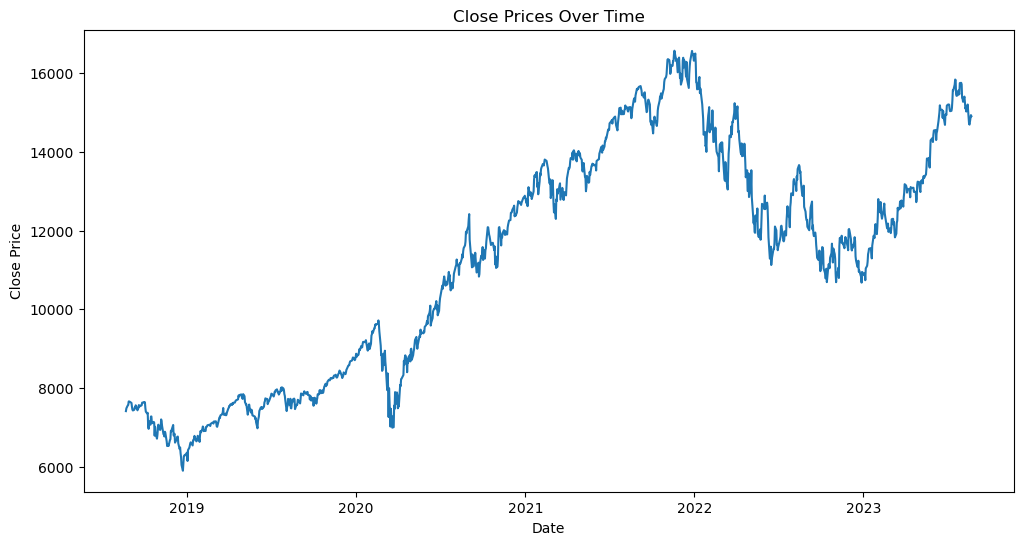

In [23]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(values['Date'], values['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.show()

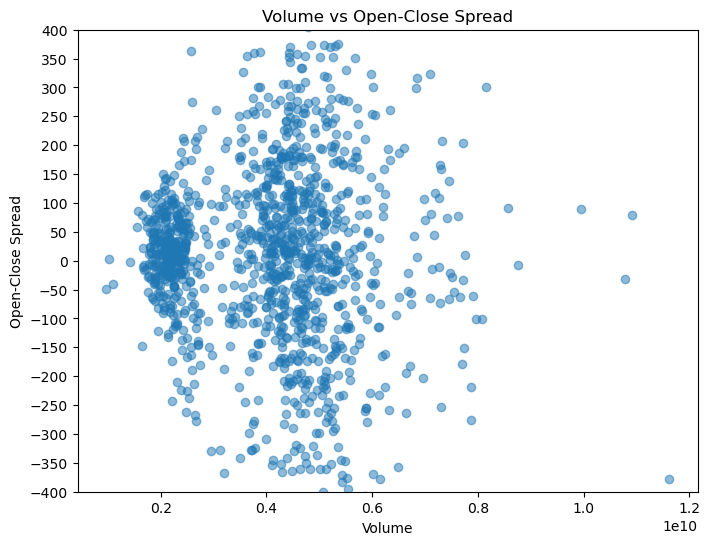

In [24]:
# Scatter Plot: Volume vs Open-Close Spread
plt.figure(figsize=(8, 6))
plt.scatter(values['Volume'], values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')
plt.ylim(-400, 400)
plt.yticks(range(-400, 401, 50))
plt.show()

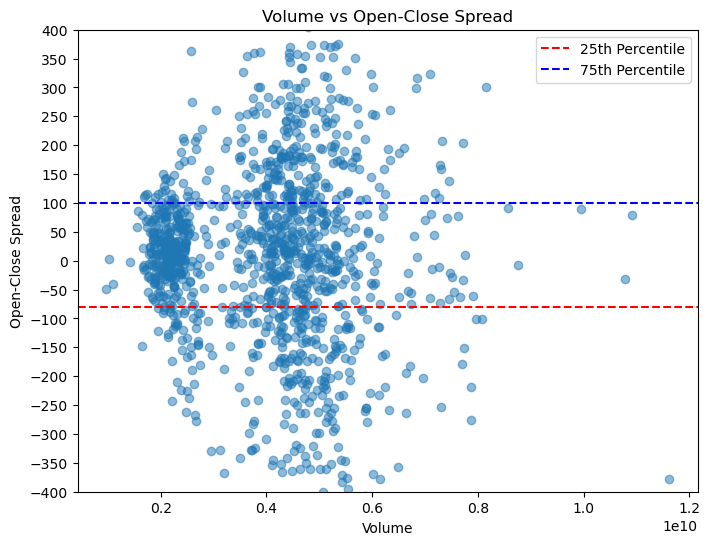

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(values['Volume'], values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')

# Set y-axis limits and tick spacing
plt.ylim(-400, 400)  # Adjust the y-axis limits as needed
plt.yticks(range(-400, 401, 50))  # Adjust the tick range and spacing as needed

# Add horizontal lines for 25th and 75th percentiles
plt.axhline(y=values['Close_Difference'].quantile(0.25), color='r', linestyle='--', label='25th Percentile')
plt.axhline(y=values['Close_Difference'].quantile(0.75), color='b', linestyle='--', label='75th Percentile')

# Add a legend
plt.legend()

plt.show()


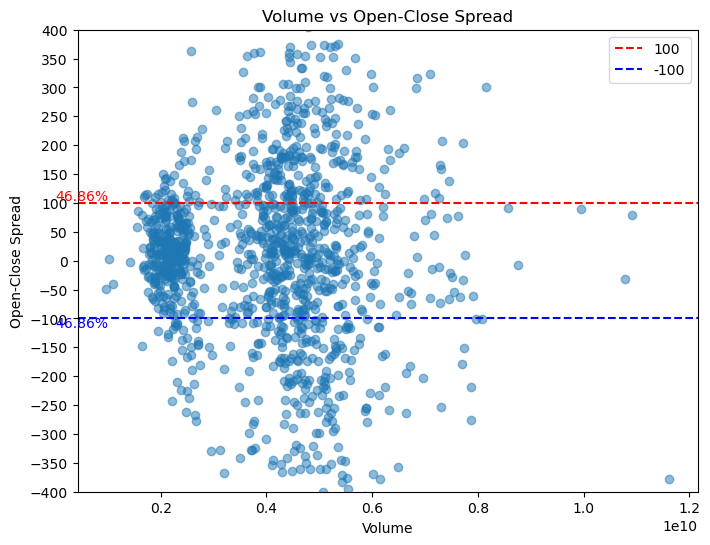

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(values['Volume'], values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')

# Set y-axis limits and tick spacing
plt.ylim(-400, 400)  # Adjust the y-axis limits as needed
plt.yticks(range(-400, 401, 50))  # Adjust the tick range and spacing as needed

# Add horizontal lines at 100 and -100
plt.axhline(y=100, color='r', linestyle='--', label='100')
plt.axhline(y=-100, color='b', linestyle='--', label='-100')

# Calculate percentage of rows between 100 and -100
percentage_between = 100 - ((values['Close_Difference'] > -100) & (values['Close_Difference'] < 100)).mean() * 100

# Annotate the percentage above the lines
plt.text(5, 105, f'{percentage_between:.2f}%', color='r', fontsize=10)
plt.text(5, -115, f'{percentage_between:.2f}%', color='b', fontsize=10)

# Add a legend
plt.legend()

plt.show()


### I wanted to dive deeper here to see how many days expereince an open close spread of 100 points in either direction and it being at half is not making me feel any better. SO I want to look at it for dates in the past 200 days

In [27]:
# Calculate the number of data points between -100 and 100
num_points_within_range = ((values['Close_Difference'] >= -100) & (values['Close_Difference'] <= 100)).sum()
total_rows = len(values)
percentage_within_range = (num_points_within_range / total_rows) * 100

print(f'Number of data points within the range (-100 to 100): {num_points_within_range}')
print(f'Percentage of total rows within the range: {percentage_within_range:.2f}%')

Number of data points within the range (-100 to 100): 668
Percentage of total rows within the range: 53.14%


In [28]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')
total_rows = len(values)
# Calculate the number of data points between -200 and 200 within the entire DataFrame
num_points_within_range200 = ((values['Close_Difference'] >= -200) & (values['Close_Difference'] <= 200)).sum()
# Calculate the percentage
percentage_within_range200 = (num_points_within_range200 / total_rows) * 100

print(f'Number of data points within the range (-200 to 200): {num_points_within_range200}')
print(f'Percentage of total rows within the range: {percentage_within_range200:.2f}%')


Number of data points within the range (-200 to 200): 977
Percentage of total rows within the range: 77.72%


#### This is a much more exciting revelation and it will appear the same for the past 200 trading days as well. Meaning we can take a position

### Filtered out to examine only the past 200 Trading Days. The rest of the visualizations to follow are from the primary dataframe

In [29]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Filter the data for the past 200 trading days
past_200_days = values.tail(200)

# Calculate the number of data points between -100 and 100 within the filtered data
num_points_within_range = ((past_200_days['Close_Difference'] >= -100) & (past_200_days['Close_Difference'] <= 100)).sum()

# Calculate the total number of rows in the filtered data
total_rows = len(past_200_days)

# Calculate the percentage
percentage_within_range = (num_points_within_range / total_rows) * 100

print(f'Number of data points within the range (-100 to 100) in the past 200 trading days: {num_points_within_range}')
print(f'Percentage of total rows within the range: {percentage_within_range:.2f}%')

Number of data points within the range (-100 to 100) in the past 200 trading days: 88
Percentage of total rows within the range: 44.00%


### Repeat of the above code but widening the range to -200,200

In [30]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Filter the data for the past 200 trading days
past_200_days = values.tail(200)

# Calculate the number of data points between -200 and 200 within the filtered data
num_points_within_range = ((past_200_days['Close_Difference'] >= -200) & (past_200_days['Close_Difference'] <= 200)).sum()

# Calculate the total number of rows in the filtered data
total_rows = len(past_200_days)

# Calculate the percentage
percentage_within_range = (num_points_within_range / total_rows) * 100

print(f'Number of data points within the range (-200 to 200) in the past 200 trading days: {num_points_within_range}')
print(f'Percentage of total rows within the range: {percentage_within_range:.2f}%')

Number of data points within the range (-200 to 200) in the past 200 trading days: 153
Percentage of total rows within the range: 76.50%


#### Some quick inferences here the lower the trading volume the more like the spread will remain between 0-250

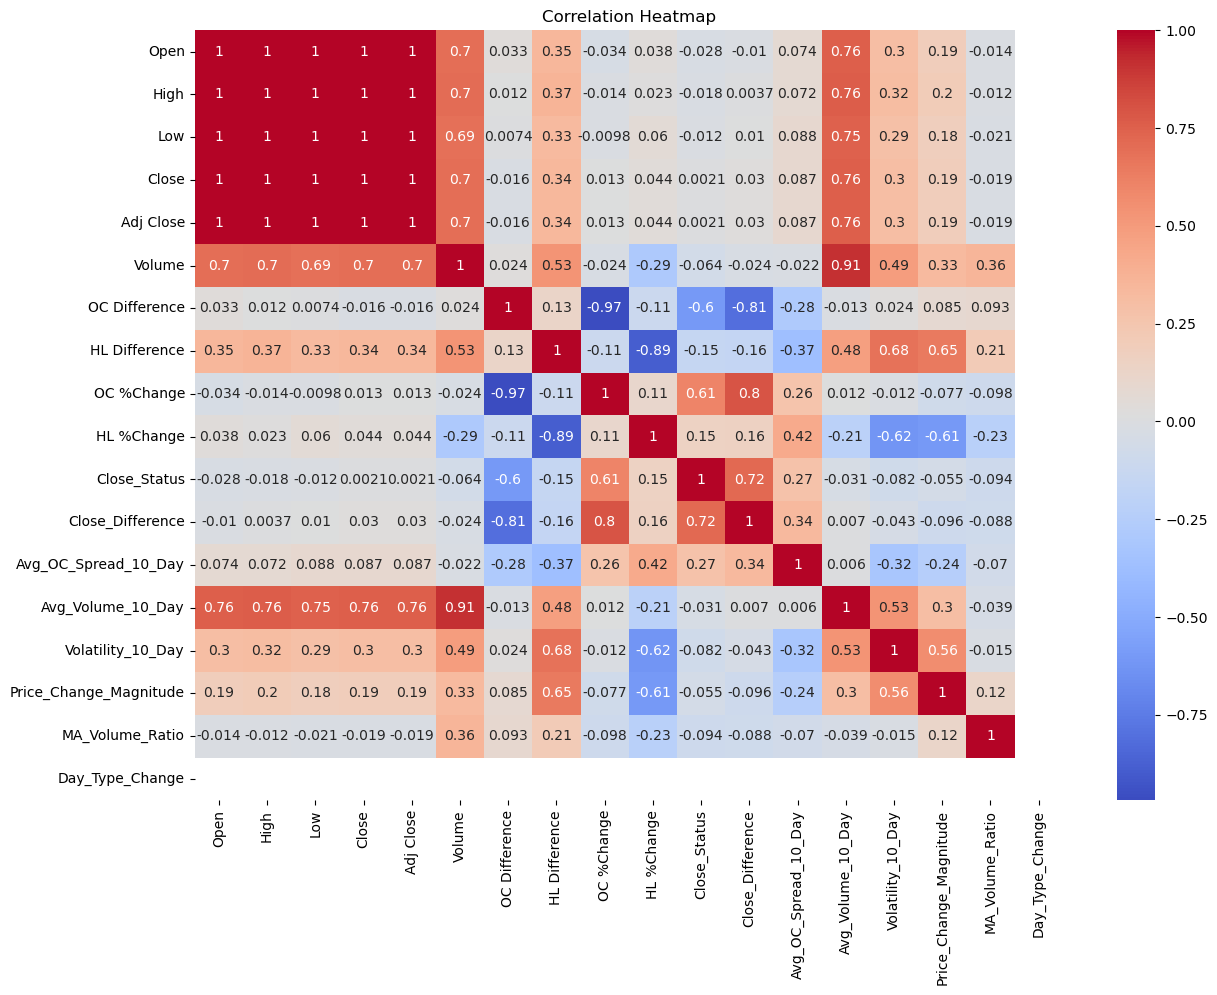

In [111]:
# Correlation Analysis
correlation_matrix = values.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

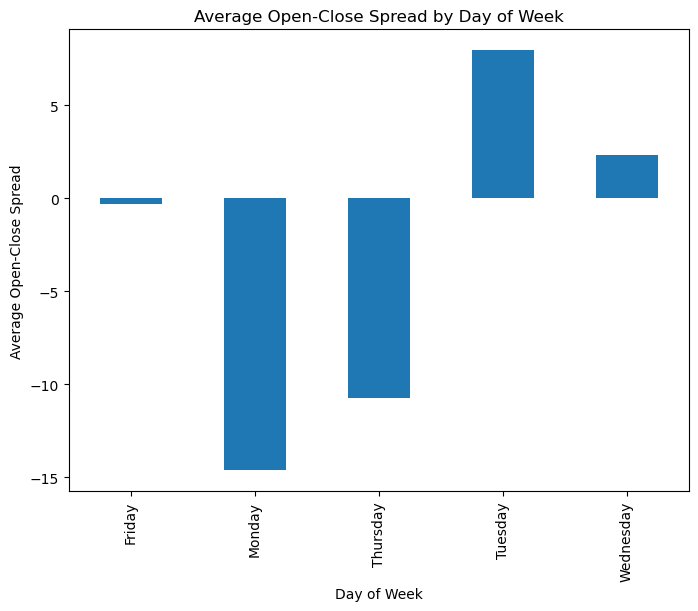

In [32]:
# Day-of-Week Analysis
avg_open_close_by_day = values.groupby('DayOfWeek')['OC Difference'].mean()
plt.figure(figsize=(8, 6))
avg_open_close_by_day.plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Average Open-Close Spread')
plt.title('Average Open-Close Spread by Day of Week')
plt.show()

In [33]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Add a new column for the day of the week
values['DayOfWeek'] = values['Date'].dt.day_name()

# Calculate the averages for each trading day of the week
avg_close_spread_diff = values.groupby('DayOfWeek')['OC Difference'].mean()
avg_volume = values.groupby('DayOfWeek')['Volume'].mean()
avg_high_low_diff = values.groupby('DayOfWeek')['HL Difference'].mean()
avg_price_change_magnitude = values.groupby('DayOfWeek')['Price_Change_Magnitude'].mean()

# Display the results
print("Average Close Spread Difference by Day of the Week:")
print(avg_close_spread_diff)
print("\nAverage Volume by Day of the Week:")
print(avg_volume)
print("\nAverage High-Low Difference by Day of the Week:")
print(avg_high_low_diff)
print("\nAverage Price Change Magnitude by Day of the Week:")
print(avg_price_change_magnitude)

Average Close Spread Difference by Day of the Week:
DayOfWeek
Friday       -0.297749
Monday      -14.615893
Thursday    -10.714987
Tuesday       7.952069
Wednesday     2.318422
Name: OC Difference, dtype: float64

Average Volume by Day of the Week:
DayOfWeek
Friday       4.131597e+09
Monday       3.925607e+09
Thursday     4.095113e+09
Tuesday      4.064870e+09
Wednesday    4.125016e+09
Name: Volume, dtype: float64

Average High-Low Difference by Day of the Week:
DayOfWeek
Friday       190.975164
Monday       183.274258
Thursday     200.834342
Tuesday      184.508329
Wednesday    193.858408
Name: HL Difference, dtype: float64

Average Price Change Magnitude by Day of the Week:
DayOfWeek
Friday       129.482829
Monday       133.422166
Thursday     141.437029
Tuesday      122.252432
Wednesday    127.948626
Name: Price_Change_Magnitude, dtype: float64


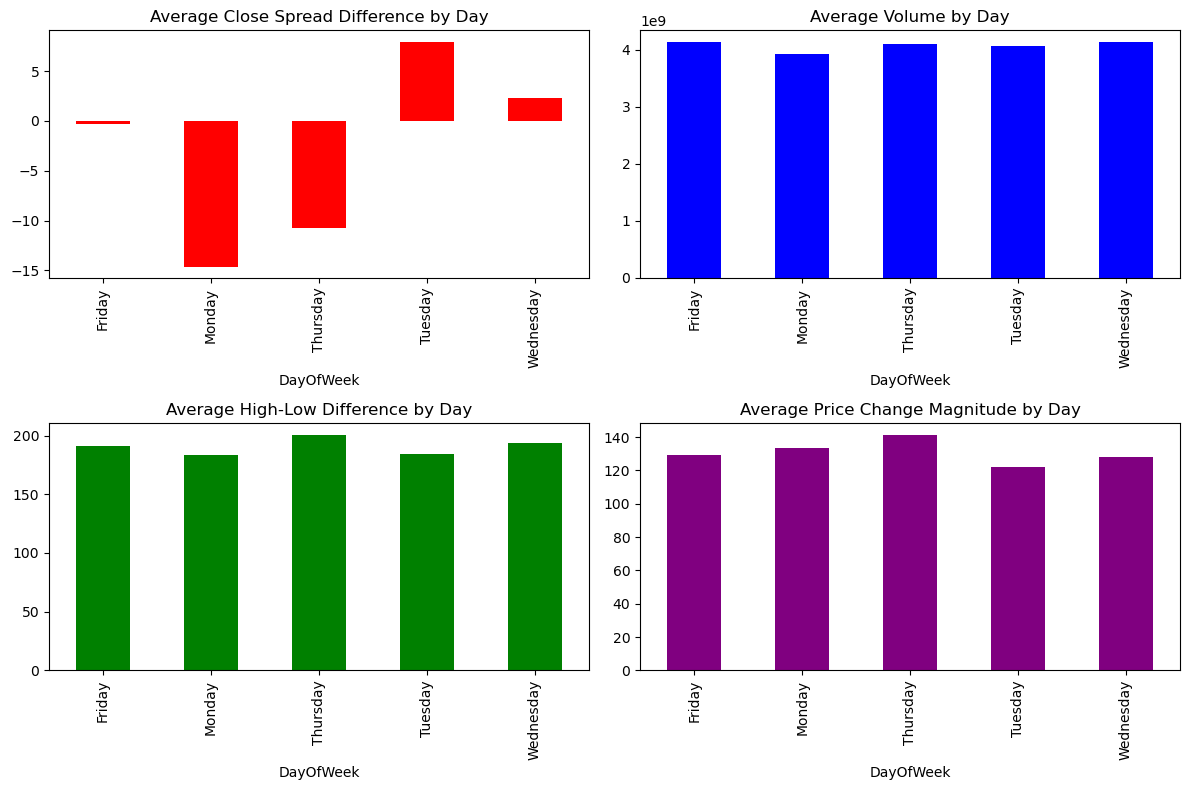

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'values' is your DataFrame
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Add a new column for the day of the week
values['DayOfWeek'] = values['Date'].dt.day_name()

# Calculate the averages for each trading day of the week
avg_close_spread_diff = values.groupby('DayOfWeek')['OC Difference'].mean()
avg_volume = values.groupby('DayOfWeek')['Volume'].mean()
avg_high_low_diff = values.groupby('DayOfWeek')['HL Difference'].mean()
avg_price_change_magnitude = values.groupby('DayOfWeek')['Price_Change_Magnitude'].mean()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Bar plots for each average
avg_close_spread_diff.plot(kind='bar', ax=axs[0, 0], color='r', title='Average Close Spread Difference by Day')
avg_volume.plot(kind='bar', ax=axs[0, 1], color='b', title='Average Volume by Day')
avg_high_low_diff.plot(kind='bar', ax=axs[1, 0], color='g', title='Average High-Low Difference by Day')
avg_price_change_magnitude.plot(kind='bar', ax=axs[1, 1], color='purple', title='Average Price Change Magnitude by Day')

# Adjust layout
plt.tight_layout()

plt.show()


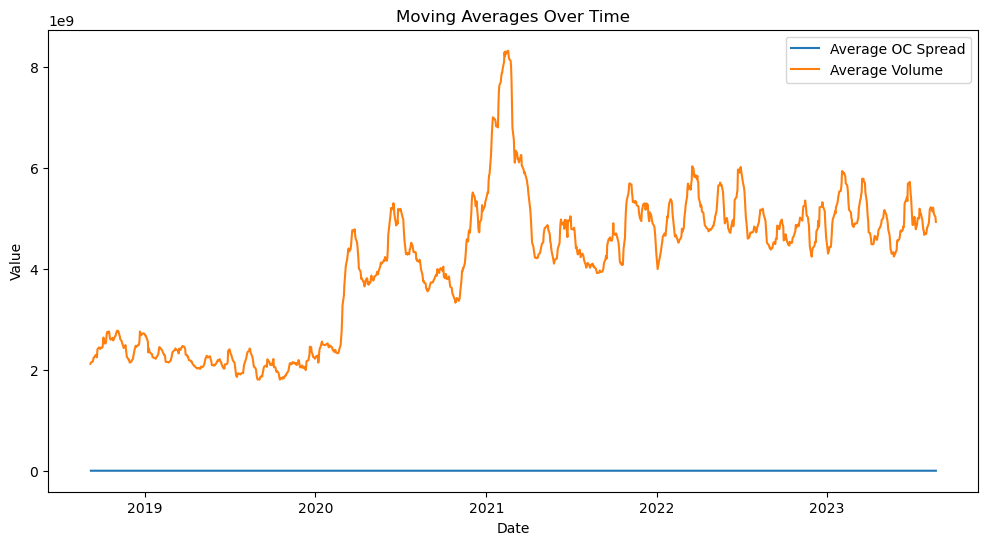

In [35]:
# Moving Averages Visualization
plt.figure(figsize=(12, 6))
plt.plot(values['Date'], values['Avg_OC_Spread_10_Day'], label='Average OC Spread')
plt.plot(values['Date'], values['Avg_Volume_10_Day'], label='Average Volume')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Averages Over Time')
plt.legend()
plt.show()

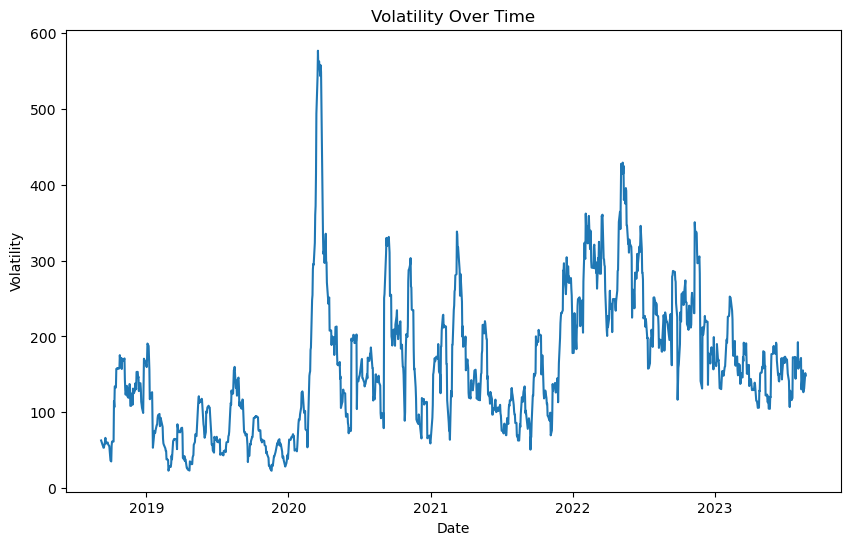

In [36]:
# Volatility Analysis
plt.figure(figsize=(10, 6))
plt.plot(values['Date'], values['Volatility_10_Day'])
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility Over Time')
plt.show()

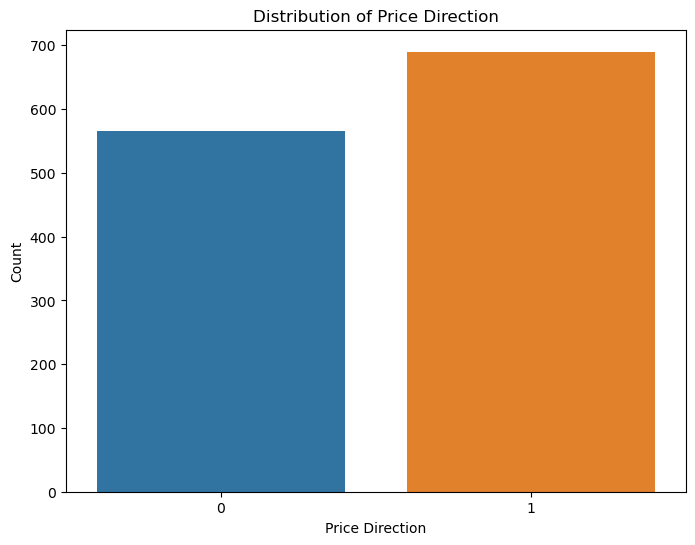

In [37]:
# Price Direction Analysis
plt.figure(figsize=(8, 6))
sns.countplot(data=values, x='Price_Direction')
plt.xlabel('Price Direction')
plt.ylabel('Count')
plt.title('Distribution of Price Direction')
plt.show()

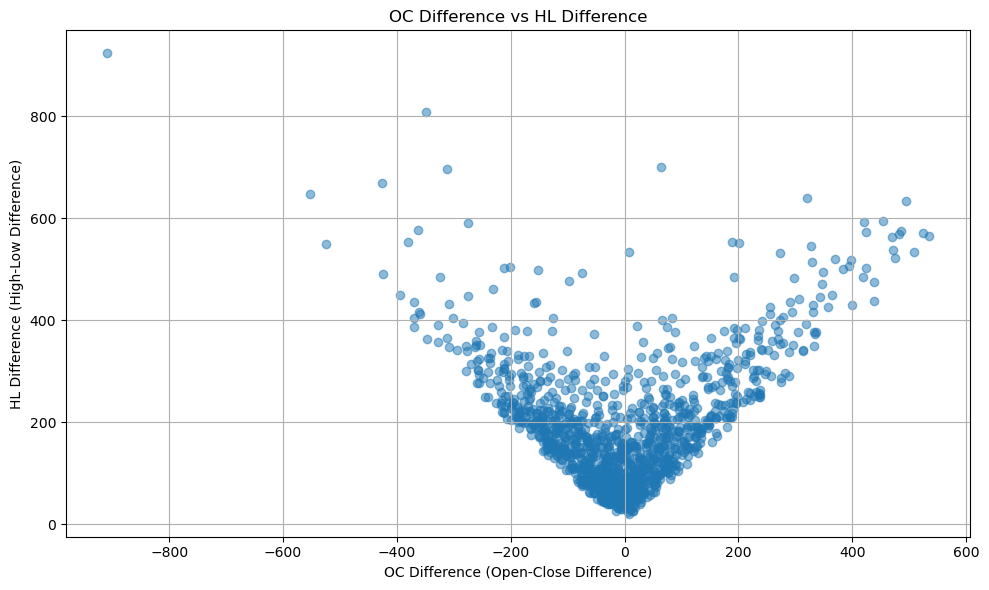

In [38]:
values = values.sort_values('Date')

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(values['OC Difference'], values['HL Difference'], alpha=0.5)
plt.xlabel('OC Difference (Open-Close Difference)')
plt.ylabel('HL Difference (High-Low Difference)')
plt.title('OC Difference vs HL Difference')
plt.grid(True)
plt.tight_layout()

plt.show()

# Modeling

### Here we are just modeling to predict close price in which we will compare its actual close price and get the spread. In Modeling Pt2. we will look at failure/success if the close landing in the same bracket as the open

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [41]:
values.tail()

,Date,DayOfWeek,Open,High,Low,Close,Adj Close,Volume,OC Difference,HL Difference,...,HL %Change,Close_Status,Close_Difference,Avg_OC_Spread_10_Day,Avg_Volume_10_Day,Volatility_10_Day,Price_Change_Magnitude,Price_Direction,MA_Volume_Ratio,Day_Type_Change
1252,2023-08-16,Wednesday,15021.629883,15077.049805,14874.019531,14876.469727,14876.469727,6243760000,145.160156,203.030274,...,-0.013466,0,-161.180664,-49.427051,5.208172e+09,126.417231,161.180664,0,1.198839,1
1253,2023-08-17,Thursday,14943.339844,14949.580078,14698.290039,14715.809570,14715.809570,5280180000,227.530274,251.290039,...,-0.016809,0,-160.660157,-63.773047,5.132493e+09,130.430060,160.660157,0,1.028775,1
1254,2023-08-18,Friday,14589.709961,14744.570313,14557.830078,14694.839844,14694.839844,4801910000,-105.129883,186.740235,...,-0.012665,0,-20.969726,-58.008008,5.077739e+09,130.973846,20.969726,0,0.945679,1
1255,2023-08-21,Monday,14762.009766,14958.870117,14739.370117,14936.690430,14936.690430,4363070000,-174.680664,219.500000,...,-0.014674,1,241.850586,-47.115918,5.024813e+09,151.532517,241.850586,1,0.868305,1
1256,2023-08-22,Tuesday,15035.070313,15037.790039,14883.980469,14908.959961,14908.959961,4282430000,126.110352,153.809570,...,-0.010228,0,-27.730469,-36.408984,4.924601e+09,148.398817,27.730469,0,0.869599,1


In [80]:
# Split data into features (X) and target variable (y)
X = values[['Open','High','Low','Volume','Avg_OC_Spread_10_Day','Avg_Volume_10_Day','MA_Volume_Ratio']]
y = values['Close']

In [81]:
# Split data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [82]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Now train your model using X_train_scaled and y_train


In [83]:
# Create and train a linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [84]:
# Make predictions
y_pred = lr.predict(X_test_scaled)

In [85]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3765.5041087662735


#### So Safe to say that linear regression and MSE score is useless here. Next we will be trying XGBoost

In [118]:
from xgboost import XGBRegressor
# Load your dataset
# Assuming 'values' is your DataFrame

# Load your dataset
# Assuming 'values' is your DataFrame

# Split data into features (X) and target variable (y)
X = values.drop(['Date', 'Close','DayOfWeek'], axis=1)  # Exclude 'Date' and 'Close' and 'DayOfWeek'
#X = values[['Open','High','Low','Volume','Avg_OC_Spread_10_Day','Avg_Volume_10_Day','MA_Volume_Ratio','HL Difference']]
y = values['Close']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create and train an XGBoost regression model
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1546.5323326036926


In [92]:
# Create a DataFrame with original data and predicted values
results_df = pd.DataFrame({'Actual_Close': y_test, 'Predicted_Close': y_pred})

results_df['Spread'] = results_df['Actual_Close'] - results_df['Predicted_Close']

In [94]:
results_df['Spread'].mean()

-0.984396326140833

In [100]:
results_df.head()

,Actual_Close,Predicted_Close,Spread
435,9331.929688,9333.367188,-1.437499
101,6784.609863,6792.293457,-7.683594
51,6937.089844,6900.039551,37.050293
63,6575.660156,6608.142090,-32.481934
1072,11756.030273,11728.129883,27.900390


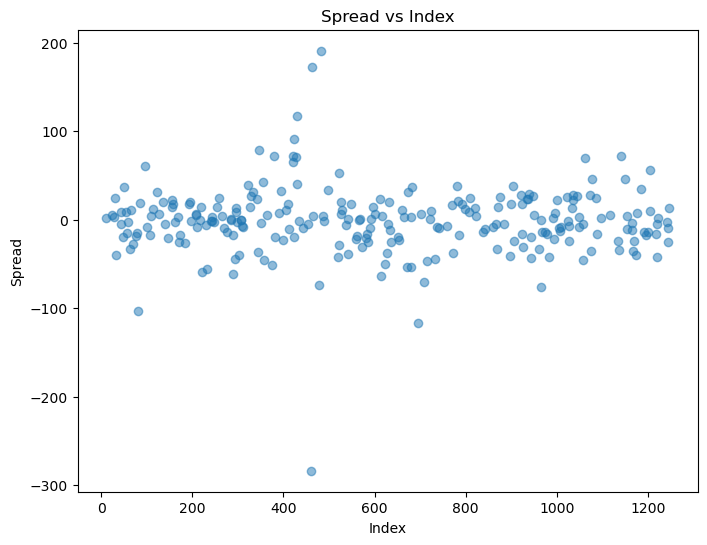

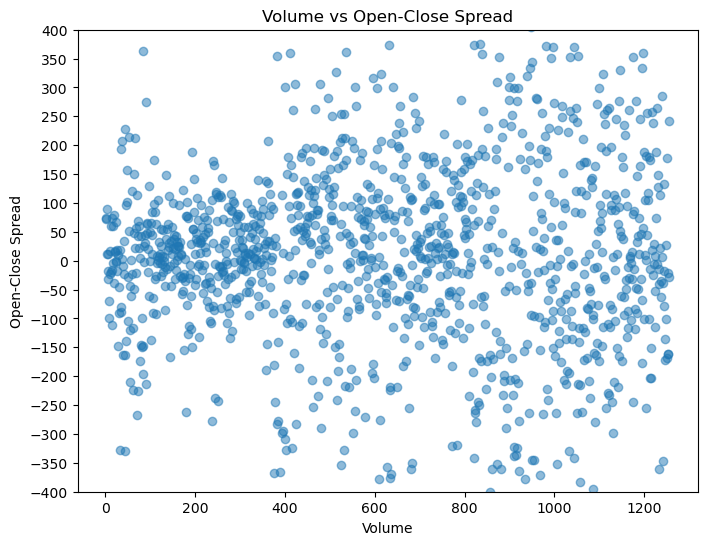

In [102]:
# Scatter plot for Spread
plt.figure(figsize=(8, 6))
plt.scatter(results_df.index, results_df['Spread'], alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Spread')
plt.title('Spread vs Index')
plt.show()
# Scatter Plot: Volume vs Open-Close Spread
plt.figure(figsize=(8, 6))
plt.scatter(values.index, values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')
plt.ylim(-400, 400)
plt.yticks(range(-400, 401, 50))
plt.show()

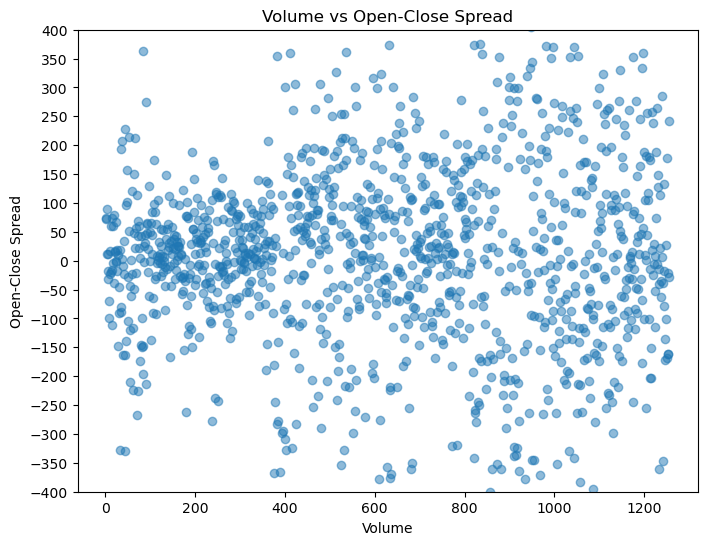

In [101]:
# Scatter Plot: Volume vs Open-Close Spread
plt.figure(figsize=(8, 6))
plt.scatter(values.index, values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')
plt.ylim(-400, 400)
plt.yticks(range(-400, 401, 50))
plt.show()

#### From what we can see above, the predicted dataframe predicts way too tightly than the actual, Although that is what we would like to see, we know truly that its not allowing for a wide variance. We are not capurting the variability that is present in the data. Not sure i its due to model complexity, feature engineering, or not enough hyper parameters.


### We are going to try hyper parameter tuning first

In [126]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

X = values.drop(['Date', 'Close', 'DayOfWeek'], axis=1)
y = values['Close']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=2)  # Set cv to 2 folds
grid_search.fit(X_train[:1000], y_train[:1000])  # Use a smaller subset of data for training

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Best Model - Mean Squared Error: {mse}')

Best Model - Mean Squared Error: 355.6338268607047


#### HUGE IMPROVEMENT!

As you can see we decided to use GridSearchCV as our tuning. We used a dictioanry of parameters for different values to test for n estiamtors and learning rate. 